/var/folders/zb/1vtwn9rj08lghdmmhfhb0d280000gn/T/ipykernel_10412/912682913.py:43: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



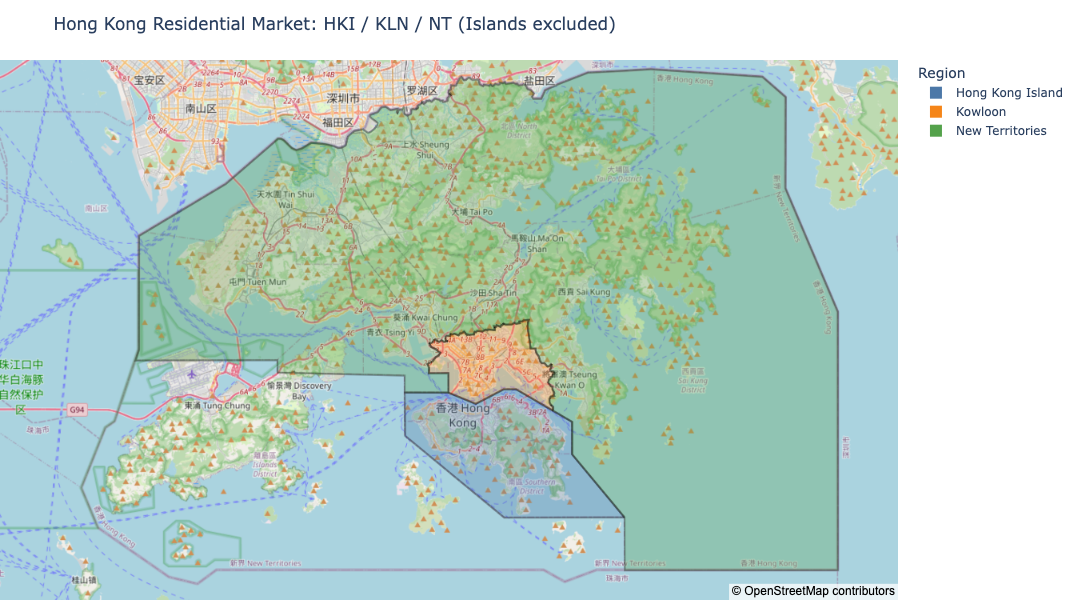

In [2]:
import requests
import geopandas as gpd
import plotly.express as px

url = "https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json"
hk_geo = requests.get(url).json()

gdf = gpd.GeoDataFrame.from_features(hk_geo["features"])


gdf = gdf.rename(columns={"District": "district"})


gdf = gdf[gdf["district"] != "Islands"].copy()


hki = ["Central & Western", "Wan Chai", "Eastern", "Southern"]
kowloon = ["Yau Tsim Mong", "Sham Shui Po", "Kowloon City", "Wong Tai Sin", "Kwun Tong"]

def map_region(d: str) -> str:
    if d in hki:
        return "Hong Kong Island"
    elif d in kowloon:
        return "Kowloon"
    else:
        return "New Territories"

gdf["Region"] = gdf["district"].apply(map_region)


region_gdf = gdf.dissolve(by="Region", as_index=False)


minx, miny, maxx, maxy = region_gdf.total_bounds
if maxx > 180:  # not lon/lat
    region_gdf = region_gdf.set_crs(2326, allow_override=True).to_crs(4326)
else:
    region_gdf = region_gdf.set_crs(4326, allow_override=True)

region_geojson = region_gdf.__geo_interface__


fig = px.choropleth_mapbox(
    region_gdf,
    geojson=region_geojson,
    locations="Region",
    featureidkey="properties.Region",
    color="Region",
    color_discrete_map={
        "Hong Kong Island": "#4c78a8",
        "Kowloon": "#f58518",
        "New Territories": "#54a24b",
    },
    height=600,
    center={"lat": 22.35, "lon": 114.15},
    zoom=9.6,
    opacity=0.3
)

fig.update_layout(
    mapbox_style="open-street-map",  
    margin=dict(l=0, r=0, t=60, b=0),
    title="Hong Kong Residential Market: HKI / KLN / NT (Islands excluded)"
)

fig.update_traces(
    marker_line_width=2,
    marker_line_color="black",
    hovertemplate="<b>%{location}</b><extra></extra>"
)

fig.show()
